In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import pickle as pkl
import pandas as pd
import torch
import os

pd.set_option('display.max_rows', None)

## Create custom dataset to load the data

In [431]:
label2num = {
    'AMBIENT': 0,
    'COLD': 1,
    'WARM': 2,
    'HOT' : 3
}

num2label = {
    0: 'AMBIENT',
    1: 'COLD',
    2: 'WARM',
    3: 'HOT',
}

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, feat_type):
        self.parent = pathlib.Path('Features')
        self.files = os.listdir(self.parent)
        self.feat_type = feat_type
        
        
    def __len__(self):
        return len(self.files)
    
    
    def __getitem__(self, k):
        fname = self.files[k]
        
        with open(self.parent / fname, 'rb') as f:
            pkg = pkl.load(f)
        
        label_str = fname.split('_')[0]
        label_num = label2num[label_str]
        
        
        if 'spectrograms' == self.feat_type:
            data = pkg[self.feat_type]
            data = torch.tensor(data[0], dtype=torch.float32)
            data = torch.flatten(data, 0)
        elif 'pwrs' == self.feat_type:
            data = pkg[self.feat_type]
            data = torch.tensor(data[0], dtype=torch.float32)
        
        elif 'signals' == self.feat_type:
            data = pkg[self.feat_type]
            data = torch.tensor(data, dtype=torch.float32)
            data = torch.flatten(data, 0)
        
        elif 'signals-2D' == self.feat_type:
            data = pkg['signals']
            data = torch.tensor(data, dtype=torch.float32)
        
        return data, label_num


## Fully Connected Prototype
Prototype simple feed forward neural network architecture.

This section just verifies programming logic, doesn't actually train. 

In [169]:
#dtype = 'spectrograms'
#dtype = 'pwrs'
dtype = 'signals'
hidden_layer_size = 50


dataset = MyDataset(dtype)
train_dloader = torch.utils.data.DataLoader(
    dataset,
    batch_size = 16,
    shuffle=True
)

single_x, single_y = dataset[0]

train_features, train_labels = next(iter(train_dloader))

print(train_features.shape)

nn1_out_len = 100
nn1 = torch.nn.Linear(single_x.shape[0], nn1_out_len)
y1  = nn1(train_features)

re1 = torch.nn.ReLU()
y2  = re1(y1)

nn2 = torch.nn.Linear(nn1_out_len, len(label2num))
y3  = nn2(y2)

re2 = torch.nn.ReLU()
y4  = re2(y3)

loss_fn = torch.nn.CrossEntropyLoss()

loss_fn(y4, train_labels)

print(y4)
(y4.argmax(1) == train_labels).sum().item()


torch.Size([16, 13860])
tensor([[0.0000, 0.0451, 0.0350, 0.0000],
        [0.0000, 0.0452, 0.0359, 0.0000],
        [0.0000, 0.0454, 0.0348, 0.0000],
        [0.0000, 0.0451, 0.0350, 0.0000],
        [0.0000, 0.0451, 0.0350, 0.0000],
        [0.0000, 0.0452, 0.0348, 0.0000],
        [0.0000, 0.0450, 0.0350, 0.0000],
        [0.0000, 0.0451, 0.0350, 0.0000],
        [0.0000, 0.0450, 0.0351, 0.0000],
        [0.0000, 0.0454, 0.0352, 0.0000],
        [0.0000, 0.0451, 0.0350, 0.0000],
        [0.0000, 0.0480, 0.0372, 0.0000],
        [0.0000, 0.0448, 0.0350, 0.0000],
        [0.0000, 0.0451, 0.0350, 0.0000],
        [0.0000, 0.0451, 0.0350, 0.0000],
        [0.0000, 0.0452, 0.0349, 0.0000]], grad_fn=<ReluBackward0>)


3

## Convert fully connected network to class and train

In [184]:
class MyNN(torch.nn.Module):
    def __init__(self):
        super(MyNN, self).__init__()
        
        nn1_out = hidden_layer_size
        nn2_out = len(label2num)
        
        self.stack = torch.nn.Sequential(
            torch.nn.Linear(single_x.shape[0], nn1_out),
            torch.nn.ReLU(),
            torch.nn.Linear(nn1_out, nn2_out),
            torch.nn.ReLU(),
        )
    
    def forward(self, x):
        return self.stack(x)
    

def accuracy(model, X, y):
    pred = model(X)
    
    correct = (pred.argmax(1) == y).sum().item()
    acc = correct / y.shape[0]
    return acc


def test(model, dloader):
    model.eval()
    acc = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dloader):
            #X = torch.nn.functional.normalize(X, dim=1, p=1)
        
            acc += accuracy(model, X, y)

    return acc / len(dloader)


def train(model, opt, loss_fn, dloader):
    model.train()
    for batch, (X, y) in enumerate(dloader):
        #X = torch.nn.functional.normalize(X, dim=1, p=1)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        #print('%d: %.3f'%(batch, loss.item()))


dataset = MyDataset(dtype)

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(
    dataset,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)
)


train_dloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 64,
    shuffle=True
)


test_dloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 128,
    shuffle=True
)


epochs = 200

loss_fn = torch.nn.CrossEntropyLoss()

fd = MyNN()

opt = torch.optim.Adam(fd.parameters())

for epoch in range(epochs):
    train(fd, opt, loss_fn, train_dloader)
    acc = test(fd, test_dloader)
    print('[%d] acc: %.3f'%(epoch, acc))

[0] acc: 0.363
[1] acc: 0.492
[2] acc: 0.597
[3] acc: 0.645
[4] acc: 0.540
[5] acc: 0.492
[6] acc: 0.468
[7] acc: 0.468
[8] acc: 0.468
[9] acc: 0.452
[10] acc: 0.452
[11] acc: 0.452
[12] acc: 0.452
[13] acc: 0.452
[14] acc: 0.452
[15] acc: 0.468
[16] acc: 0.468
[17] acc: 0.476
[18] acc: 0.492
[19] acc: 0.492
[20] acc: 0.484
[21] acc: 0.484
[22] acc: 0.524
[23] acc: 0.524
[24] acc: 0.532
[25] acc: 0.524
[26] acc: 0.565
[27] acc: 0.565
[28] acc: 0.556
[29] acc: 0.573
[30] acc: 0.589
[31] acc: 0.597
[32] acc: 0.605
[33] acc: 0.605
[34] acc: 0.605
[35] acc: 0.613
[36] acc: 0.605
[37] acc: 0.694
[38] acc: 0.871
[39] acc: 0.645
[40] acc: 0.637
[41] acc: 0.871
[42] acc: 0.895
[43] acc: 0.879
[44] acc: 0.637
[45] acc: 0.879
[46] acc: 0.879
[47] acc: 0.815
[48] acc: 0.677
[49] acc: 0.855
[50] acc: 0.871
[51] acc: 0.637
[52] acc: 0.887
[53] acc: 0.879
[54] acc: 0.750
[55] acc: 0.871
[56] acc: 0.831
[57] acc: 0.726
[58] acc: 0.798
[59] acc: 0.863
[60] acc: 0.702
[61] acc: 0.806
[62] acc: 0.871
[6

### Conclusion
* Feedforward network was able to achieve 93% accuracy.
* Good indication that convolutional network will work.

## Prototype Convolutional Network

This section just verifies programming logic

In [303]:
dataset = MyDataset('signals-2D')

train_dloader = torch.utils.data.DataLoader(
    dataset,
    batch_size = 32,
    shuffle=True
)

print(dataset[0][0].shape)

X, y = next(iter(train_dloader))

print('X: ', X.shape)
print()

cnn1_len = 128

cnn1_out_chan = 6
cnn1 = torch.nn.Conv2d(
    in_channels=3,
    out_channels=cnn1_out_chan,
    kernel_size=(X.shape[2], cnn1_len)
)
y1_exp = X.shape[3] - cnn1_len + 1
y1 = cnn1(X)
print('act y1: ', y1.shape)
print('exp y1: ', y1_exp)
print()

f1 = torch.nn.Flatten(2)
y2 = f1(y1)
print('y2: ', y2.shape)
print()


cnn2_len = 16
cnn2 = torch.nn.Conv1d(
    in_channels=cnn1_out_chan,
    out_channels=1,
    kernel_size=cnn2_len
)

y2a = cnn2(y2)
y2a_exp = y1_exp - cnn2_len + 1

print('act y2a: ', y2a.shape)
print('exp y2a: ', y2a_exp)
print()

f2 = torch.nn.Flatten(1)
y2b = f2(y2a)

p1_len = 4
p1 = torch.nn.MaxPool1d(kernel_size=p1_len)
y3 = p1(y2b)
y3_exp = y2a_exp // p1_len

print('act y3: ', y3.shape)
print('exp y3: ', y3_exp)
print()


r1 = torch.nn.ReLU()
y4 = r1(y3)

n1_len = 32
n1 = torch.nn.Linear(
    y3_exp,
    n1_len,
)
r2 = torch.nn.ReLU()

y5 = r2(n1(y4))


n2_len = len(label2num)
n2 = torch.nn.Linear(
    n1_len,
    n2_len,
)
r3 = torch.nn.ReLU()

y6 = r3(n2(y5))

y6.shape


torch.Size([3, 12, 385])
X:  torch.Size([32, 3, 12, 385])

act y1:  torch.Size([32, 6, 1, 258])
exp y1:  258

y2:  torch.Size([32, 6, 258])

act y2a:  torch.Size([32, 1, 243])
exp y2a:  243

act y3:  torch.Size([32, 60])
exp y3:  60



torch.Size([32, 4])

## Define Convolutional NN Class + Train

In [377]:
class DynamicLayer(torch.nn.Module):
    def __init__(self, kernel1_size, out_groups, kernel2_size, pool_size):
        super(DynamicLayer, self).__init__()
        
        # -----------------------------------------
        # Input size computation
        dataset = MyDataset('signals-2D')
        x, y = dataset[0]
        print('input: ', x.shape)
        
        # -----------------------------------------
        # CNN 1
        cnn1 = torch.nn.Conv2d(
            in_channels=x.shape[0],
            out_channels=out_groups,
            kernel_size=(x.shape[1], kernel1_size)
        )
        y1_exp = x.shape[2] - kernel1_size + 1
        print('cnn1 out: ', y1_exp)
        
        # -----------------------------------------
        # Flatten 1
        f1 = torch.nn.Flatten(2)

        # -----------------------------------------
        # CNN 2
        cnn2 = torch.nn.Conv1d(
            in_channels=out_groups,
            out_channels=1,
            kernel_size=kernel2_size
        )
        y2a_exp = y1_exp - kernel2_size + 1
        print('cnn2 out: ', y2a_exp)
        
        # -----------------------------------------
        # Flatten 2
        f2 = torch.nn.Flatten(1)
        
        
        # -----------------------------------------
        # Average Pooling 
        p1 = torch.nn.AvgPool1d(kernel_size=pool_size)
        y3_exp = y2a_exp // pool_size

        print('nn input / pool out: ', y3_exp)
        self.output_size = y3_exp
        
        
        # -----------------------------------------
        # Rectifier 1 
        r1 = torch.nn.LeakyReLU()

        self.stack = torch.nn.Sequential(
            cnn1,
            f1,
            cnn2,
            f2,
            p1,
            r1,
        )

    def forward(self, x):
        return self.stack(x)


class StaticLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_layers):
        super(StaticLayer, self).__init__()

        n1 = torch.nn.Linear(
            input_size,
            hidden_layers,
        )
        r2 = torch.nn.LeakyReLU()

        n2 = torch.nn.Linear(
            hidden_layers,
            len(label2num),
        )
        
        self.stack = torch.nn.Sequential(
            n1,
            r2,
            n2,
        )

    
    def forward(self, x):
        return self.stack(x)


class MyCNN(torch.nn.Module):
    def __init__(self, kernel1_size, out_groups, kernel2_size, pool_size, hidden_layers):
        super(MyCNN, self).__init__()
        
        self.dynamic = DynamicLayer(
            kernel1_size,
            out_groups,
            kernel2_size,
            pool_size,
        )
        
        self.static = StaticLayer(
            self.dynamic.output_size,
            hidden_layers,
        )
        
        self.stack = torch.nn.Sequential(
            self.dynamic,
            self.static,
        )
    
    def forward(self, x):
        return self.stack(x)


In [381]:
dataset = MyDataset('signals-2D')

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(
    dataset,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

train_dloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 16,
    shuffle=True
)

test_dloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 128,
    shuffle=True
)



loss_fn = torch.nn.CrossEntropyLoss()

#def __init__(self, kernel1_size, out_groups, kernel2_size, pool_size, hidden_layers):

epochs = 50

if False:
    print('creating fd')
    fd = MyCNN(
        kernel1_size=64,
        out_groups=1,
        kernel2_size=8,
        pool_size=8,
        hidden_layers=30
    )

opt = torch.optim.Adam(fd.parameters())
#opt = torch.optim.Adagrad(fd.parameters())

for epoch in range(epochs):
    train(fd, opt, loss_fn, train_dloader)
    acc = test(fd, test_dloader)
    print('[%d] acc: %.3f'%(epoch, acc))

[0] acc: 0.927
[1] acc: 0.944
[2] acc: 0.935
[3] acc: 0.927
[4] acc: 0.927
[5] acc: 0.927
[6] acc: 0.935
[7] acc: 0.935
[8] acc: 0.927
[9] acc: 0.935
[10] acc: 0.935
[11] acc: 0.935
[12] acc: 0.927
[13] acc: 0.935
[14] acc: 0.927
[15] acc: 0.927
[16] acc: 0.927
[17] acc: 0.935
[18] acc: 0.927
[19] acc: 0.935
[20] acc: 0.944
[21] acc: 0.927
[22] acc: 0.952
[23] acc: 0.935
[24] acc: 0.935
[25] acc: 0.944
[26] acc: 0.935
[27] acc: 0.935
[28] acc: 0.927
[29] acc: 0.935
[30] acc: 0.935
[31] acc: 0.927
[32] acc: 0.935
[33] acc: 0.935
[34] acc: 0.935
[35] acc: 0.935
[36] acc: 0.935
[37] acc: 0.927
[38] acc: 0.976
[39] acc: 0.944
[40] acc: 0.935
[41] acc: 0.935
[42] acc: 0.935
[43] acc: 0.944
[44] acc: 0.944
[45] acc: 0.935
[46] acc: 0.927
[47] acc: 0.935
[48] acc: 0.944
[49] acc: 0.944


### Conclusion
* Network was able to achieve 94% accuracy

In [382]:
torch.save(fd, 'cnn11')

In [558]:
load_cnn = torch.load('cnn11')
load_cnn

MyCNN(
  (dynamic): DynamicLayer(
    (stack): Sequential(
      (0): Conv2d(3, 1, kernel_size=(12, 64), stride=(1, 1))
      (1): Flatten(start_dim=2, end_dim=-1)
      (2): Conv1d(1, 1, kernel_size=(8,), stride=(1,))
      (3): Flatten(start_dim=1, end_dim=-1)
      (4): AvgPool1d(kernel_size=(8,), stride=(8,), padding=(0,))
      (5): LeakyReLU(negative_slope=0.01)
    )
  )
  (static): StaticLayer(
    (stack): Sequential(
      (0): Linear(in_features=39, out_features=30, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=30, out_features=4, bias=True)
    )
  )
  (stack): Sequential(
    (0): DynamicLayer(
      (stack): Sequential(
        (0): Conv2d(3, 1, kernel_size=(12, 64), stride=(1, 1))
        (1): Flatten(start_dim=2, end_dim=-1)
        (2): Conv1d(1, 1, kernel_size=(8,), stride=(1,))
        (3): Flatten(start_dim=1, end_dim=-1)
        (4): AvgPool1d(kernel_size=(8,), stride=(8,), padding=(0,))
        (5): LeakyReLU(negative_slope=0.0

## Prototype Realtime Implementation

In [559]:
from scipy import signal

### Prototype Realtime 2D Convolutional Section

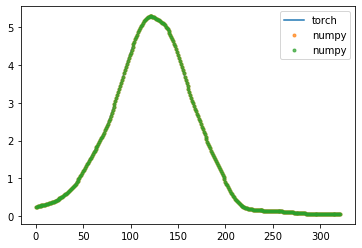

In [871]:

class RealTimeConv2D(object):
    def __init__(self, torch_cnn2d, omit_warmup=False):
        with torch.no_grad():
            self.kernel = torch_cnn2d.weight.squeeze(0).numpy()
            self.bias   = torch_cnn2d.bias.squeeze(0).item()

            self.kernel_len = self.kernel.shape[2]
            self.kernel_bin = self.kernel.shape[1]
            self.kernel_chn = self.kernel.shape[0]
            
            self.cache_len = self.kernel.shape[2] - 1
            self.cache = np.zeros(
                (self.kernel.shape[1], self.cache_len)
            )
            self.omit_warmup = omit_warmup
    
    def __prepend_cache(self, data):
        new_data = np.zeros(
            (data.shape[0], data.shape[1], data.shape[2] + self.cache_len)
        )
        
        new_data[:, :, :self.cache_len] = self.cache
        new_data[:, :, self.cache_len:] = data
        return new_data
    
    def convolve(self, data):
        if not self.omit_warmup:
            data = self.__prepend_cache(data)
        
        self.omit_warmup = False
        
        data_chan = data.shape[0]
        data_freq = data.shape[1]
        data_time = data.shape[2]
        
        exp_len = data_time - self.kernel_len + 1 
        
        out = np.zeros((1, exp_len))
        
        for chan in range(data_chan):
            out += signal.correlate2d(
                data[chan], 
                self.kernel[chan], 
                mode='valid'
            )

        out += self.bias
        
        self.cache = data[:, :, -self.cache_len:]
        
        return out.squeeze(0)

load_cnn = torch.load('cnn11')

X, y = dataset[300]

torch_cnn = load_cnn.dynamic.stack[0]
realt_chunk_cnn = RealTimeConv2D(torch_cnn, omit_warmup=True)
realt_whole_cnn = RealTimeConv2D(torch_cnn, omit_warmup=True)

with torch.no_grad():

    torch_out = torch_cnn(
        X.unsqueeze(0)
    ).flatten(0).numpy()
    
    data = X.numpy()
    
    datalen = data.shape[2]
    ind = datalen//2
    
    out = []
    
    realt_chunk_out = np.concatenate([
        realt_chunk_cnn.convolve(chunk)
        for chunk in [data[:, :, :ind], data[:, :, ind:]]
    ])
    
    realt_whole_out = realt_whole_cnn.convolve(data)


plt.plot(torch_out, label='torch')
plt.plot(realt_chunk_out, '.', alpha=0.7, label='numpy')
plt.plot(realt_whole_out, '.', alpha=0.7, label='numpy')

plt.legend()

### Prototype Realtime 1D Convolutional Section

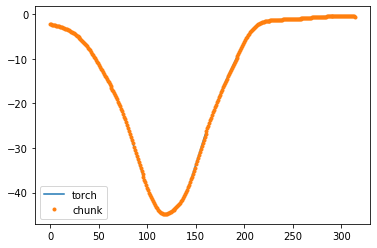

In [872]:
class RealTimeConv1D(object):
    def __init__(self, torch_cnn1d, omit_warmup=False):
        with torch.no_grad():
            self.kernel = torch_cnn1d.weight.flatten(0).numpy()
            self.bias   = torch_cnn1d.bias.item()
            self.kernel_len = self.kernel.shape[0]
            self.cache  = np.zeros(self.kernel_len - 1)
            self.cache_len = self.kernel_len - 1
            self.omit_warmup = omit_warmup
            
    def __prepend_cache(self, data):
        new_data = np.zeros(len(data) + self.cache_len)
        new_data[:self.cache_len] = self.cache
        new_data[self.cache_len:] = data
        return new_data
    
    def __update_cache(self, data):
        self.cache = data[-self.cache_len:]

    def convolve(self, data):
        
        if not self.omit_warmup:
            data = self.__prepend_cache(data)
        
        self.omit_warmup = False
        
        out = signal.correlate(data, self.kernel, mode='valid') + self.bias
        
        self.__update_cache(data)
    
        return out


def chunk_data(data, parts):
    length = len(data) // parts
    offset = 0
    
    while True:
        end_ind = min(offset + length, len(data))
        
        chunk = data[offset:end_ind]
        yield chunk
        
        offset = end_ind
        
        if offset == len(data):
            break


load_cnn = torch.load('cnn11')


realt_whole_cnn2d = RealTimeConv2D(load_cnn.dynamic.stack[0], omit_warmup=True)

realt_chunk_cnn1d = RealTimeConv1D(load_cnn.dynamic.stack[2], omit_warmup=True)

X, y = dataset[300]

with torch.no_grad():

    Xin = X.unsqueeze(0)

    #Xtest = load_cnn.dynamic.stack[1](
    #    load_cnn.dynamic.stack[0](Xin)
    #).flatten(0).numpy()
    
    realt_2d_out = realt_whole_cnn2d.convolve(X.numpy())
    
    realt_1d_out = np.concatenate([
        realt_chunk_cnn1d.convolve(chunk)
        for chunk in chunk_data(realt_2d_out, 4)
    ])
    
    
    Yout = load_cnn.dynamic.stack[2](
        load_cnn.dynamic.stack[1](
            load_cnn.dynamic.stack[0](Xin)
        )
    ).flatten(0).numpy()
    
    
plt.plot(Yout, label='torch')
plt.plot(realt_1d_out, '.', label='chunk')
plt.legend()

### Prototype Realtime Max Pooling Layer 

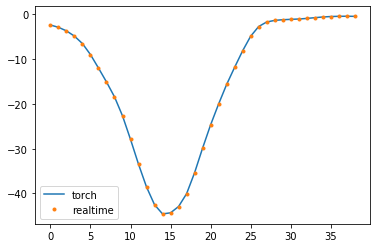

In [873]:
class RealTimeAvgPool(object):
    def __init__(self, num):
        self.num = num
        self.cache = None
        self.kernel = np.matrix(np.ones((1, num))/num)
    
    def __format_and_cache(self, data):
        if self.cache is not None:
            data = np.concatenate((self.cache, data))
        
        remainder = len(data) % self.num
        if 0 < remainder:
            self.cache = data[-remainder:]
            return data[:-remainder]
        else:
            self.cache = None
            return data
        
    def downsample(self, data):
        data = self.__format_and_cache(data)
        return (self.kernel @ np.matrix(data.reshape(-1, self.num).T)).A1


load_cnn = torch.load('cnn11')

realt_cnn2d = RealTimeConv2D(load_cnn.dynamic.stack[0], omit_warmup=True)

realt_cnn1d = RealTimeConv1D(load_cnn.dynamic.stack[2], omit_warmup=True)

realt_avgpl = RealTimeAvgPool(8)


X, y = dataset[300]

with torch.no_grad():

    Xin = X.unsqueeze(0)

    #Xtest = load_cnn.dynamic.stack[1](
    #    load_cnn.dynamic.stack[0](Xin)
    #).flatten(0).numpy()
    
    realt_2d_out = realt_cnn2d.convolve(X.numpy())
    
    realt_1d_out = realt_cnn1d.convolve(realt_2d_out)
    
    #realt_pl_out = realt_avgpl.downsample(realt_1d_out)
    
    realt_pl_out = np.concatenate([
        realt_avgpl.downsample(chunk)
        for chunk in chunk_data(realt_1d_out, 5)
    ])
    
    
    torch_out = \
    load_cnn.dynamic.stack[4](
        load_cnn.dynamic.stack[3](
            load_cnn.dynamic.stack[2](
                load_cnn.dynamic.stack[1](
                    load_cnn.dynamic.stack[0](Xin)
                )
            )
        )
    ).flatten(0).numpy()
    
    
plt.plot(torch_out, label='torch')
plt.plot(realt_pl_out, '.', label='realtime')
plt.legend()

### Prototype Realtime Rectified Linear Unit

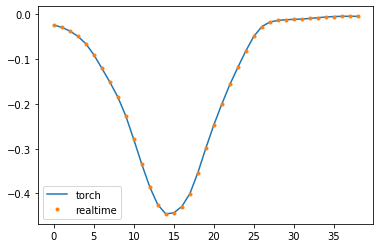

In [877]:
class RealTimeReLU(object):
    def __init__(self, alpha=0.01):
        self.alpha = np.abs(alpha)
        self.relu = np.vectorize(lambda x: x if x >= 0 else self.alpha * x)

    def rectify(self, x):
        return self.relu(x)


load_cnn = torch.load('cnn11')

realt_cnn2d = RealTimeConv2D(load_cnn.dynamic.stack[0], omit_warmup=True)

realt_cnn1d = RealTimeConv1D(load_cnn.dynamic.stack[2], omit_warmup=True)

realt_avgpl = RealTimeAvgPool(8)

realt_reclu = RealTimeReLU()


X, y = dataset[300]

with torch.no_grad():

    Xin = X.unsqueeze(0)

    #Xtest = load_cnn.dynamic.stack[1](
    #    load_cnn.dynamic.stack[0](Xin)
    #).flatten(0).numpy()
    
    realt_2d_out = realt_cnn2d.convolve(X.numpy())
    
    realt_1d_out = realt_cnn1d.convolve(realt_2d_out)
    
    realt_pl_out = realt_avgpl.downsample(realt_1d_out)
    
    #realt_pl_out = np.concatenate([
    #    realt_avgpl.downsample(chunk)
    #    for chunk in chunk_data(realt_1d_out, 5)
    #])
    
    realt_lu_out = realt_reclu.rectify(realt_pl_out)
    
    torch_out = \
    load_cnn.dynamic.stack[5](
        load_cnn.dynamic.stack[4](
            load_cnn.dynamic.stack[3](
                load_cnn.dynamic.stack[2](
                    load_cnn.dynamic.stack[1](
                        load_cnn.dynamic.stack[0](Xin)
                    )
                )
            )
        )
    ).flatten(0).numpy()
    
    
plt.plot(torch_out, label='torch')
plt.plot(realt_lu_out, '.', label='realtime')
plt.legend()

In [812]:
load_cnn.static

StaticLayer(
  (stack): Sequential(
    (0): Linear(in_features=39, out_features=30, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=30, out_features=4, bias=True)
  )
)

### Prototype Realtime Neural Network

In [838]:
import scipy

torch.Size([3, 12, 385])
Torch:  [0. 1. 0. 0.]
1
3
0


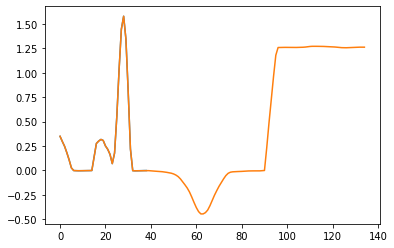

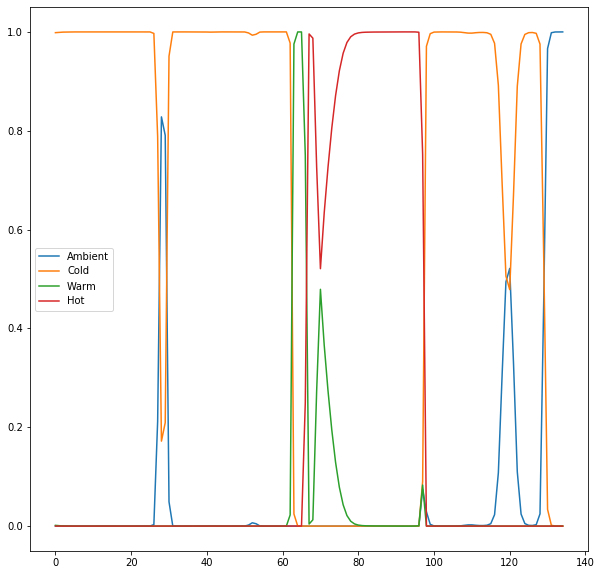

In [890]:
class RealTimeNN(object):
    def __init__(self, torch_nn):
        self.nn = torch_nn
        self.kernel_size = torch_nn.stack[0].in_features
        self.cache_len = self.kernel_size - 1
        self.cache = np.zeros(self.cache_len)
        self.relu = np.vectorize(lambda x: x if x >= 0 else -0.01 * x)
        
        with torch.no_grad():
            self.n1_weig = np.matrix(torch_nn.stack[0].weight.numpy())
            self.n1_bias = torch_nn.stack[0].bias.numpy().reshape(-1, 1)
            self.n2_weig = np.matrix(torch_nn.stack[2].weight.numpy())
            self.n2_bias = torch_nn.stack[2].bias.numpy().reshape(-1, 1)
    
    
    def evaluate(self, data):
        data = np.matrix(data.reshape(self.kernel_size, 1))
        
        n1a_out = (self.n1_weig @ data) + self.n1_bias
    
        n1b_out = self.relu(n1a_out)
        
        n2_out = ((self.n2_weig @ n1b_out) + self.n2_bias).A1
        
        return n2_out
    
    
    def __prepend_cache(self, data):
        new_data = np.zeros(len(data) + self.cache_len)
        new_data[:self.cache_len] = self.cache
        new_data[self.cache_len:] = data
        return new_data
    
    
    def __update_cache(self, data):
        self.cache = data[-self.cache_len:]

        
    def predict(self, data):
        
        data = self.__prepend_cache(data)
        
        star_ind = 0
        stop_ind = star_ind + self.kernel_size
        
        predictions = []
        
        while stop_ind <= len(data):
            p = self.evaluate(data[star_ind:stop_ind])
            predictions.append(scipy.special.softmax(p))
            
            star_ind +=1
            stop_ind +=1
        
        
        self.__update_cache(data)
    
        return np.array(predictions)

        
load_cnn = torch.load('cnn11')


realt_cnn2d = RealTimeConv2D(load_cnn.dynamic.stack[0], omit_warmup=True)
realt_cnn1d = RealTimeConv1D(load_cnn.dynamic.stack[2], omit_warmup=True)
realt_avgpl = RealTimeAvgPool(8)
realt_reclu = RealTimeReLU()
realt_nn = RealTimeNN(load_cnn.static)



X1, y1 = dataset[100]
X2, y2 = dataset[300]
X3, y3 = dataset[0]

print(X1.shape)

Xtot = torch.cat((X1, X2, X3), 2)


realt_lu_out = realt_reclu.rectify(
    realt_avgpl.downsample(
        realt_cnn1d.convolve(
            realt_cnn2d.convolve(Xtot.numpy())
        )
    )
)


realt_nn_out = realt_nn.predict(
    realt_lu_out
)

#for p in realt_nn_out:
#    print('Pred: ', ' '.join('%.3f'%x for x in scipy.special.softmax(p)))


with torch.no_grad():

    Xin = X1.unsqueeze(0)

    torch_dyn_out = load_cnn.dynamic(Xin)
    numpy_dyn_out = torch_dyn_out.flatten(0).numpy()
    
    torch_out = load_cnn(Xin).flatten(0).numpy()

print('Torch: ', scipy.special.softmax(torch_out))


plt.plot(numpy_dyn_out)
plt.plot(realt_lu_out)

plt.figure(figsize=(10,10))

print(y1)
print(y2)
print(y3)

plt.plot(realt_nn_out[:,0], label='Ambient')
plt.plot(realt_nn_out[:,1], label='Cold')
plt.plot(realt_nn_out[:,2], label='Warm')
plt.plot(realt_nn_out[:,3], label='Hot')
plt.legend()
